In [51]:
try:
    import torch
    import torchvision
    assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
    assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.1+cu121
torchvision version: 0.16.1+cu121


<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_5225/2401564698.py:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torch.__version__.split('.')[0]) >= 2 or int(torch.__version__.split(".")[1]) >= 12, "torch version must be greater than 1.12")
/tmp/ipykernel_5225/2401564698.py:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(int(torchvision.__version__.split(".")[1]) >= 13, "torch version must be greater than 0.13")


In [52]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [54]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [55]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [56]:
# From ViT Paper, the image size is 224
IMG_SIZE = 224

# Manual Transform Pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually Created Transforms: {manual_transforms}")

Manually Created Transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [57]:
# Setting the Batch size 
BATCH_SIZE = 32

# Creating Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x72c8544b8220>,
 ['pizza', 'steak', 'sushi'])

### Visualizing an Image

In [58]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

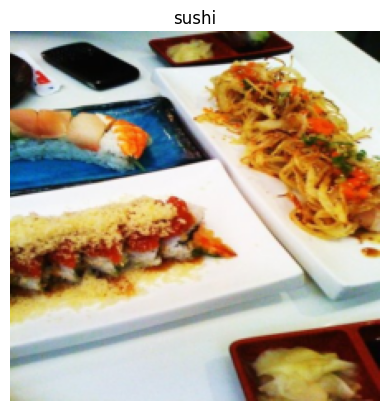

In [59]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

### Calculating Input and Output Patch Embedding Shapes by Hand

In [60]:
# Create exmple values (224 because thats what the training resolution is)
height=224
width=224
color_channels=3
patch_size=16

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [61]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

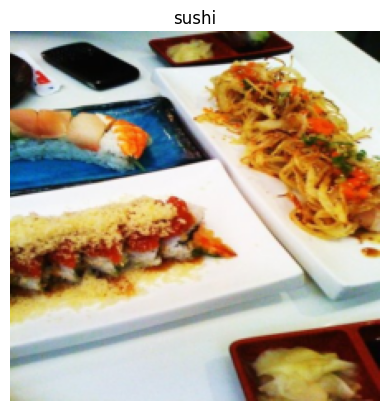

In [62]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

### Turning Images into patches

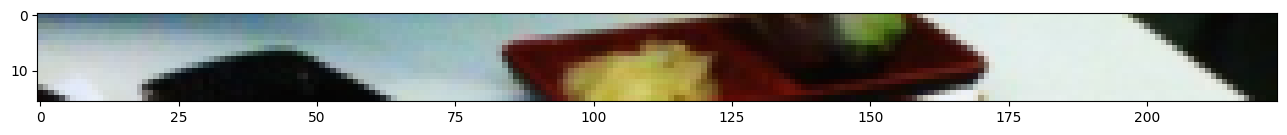

In [63]:
image_permuted = image.permute(1,2,0)

patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


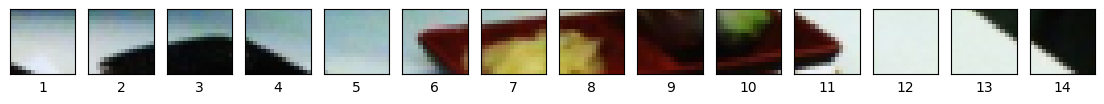

In [64]:
# Setup hyperparameters and make sure image size and patch size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image Size Must Be Divisible by Patch Size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


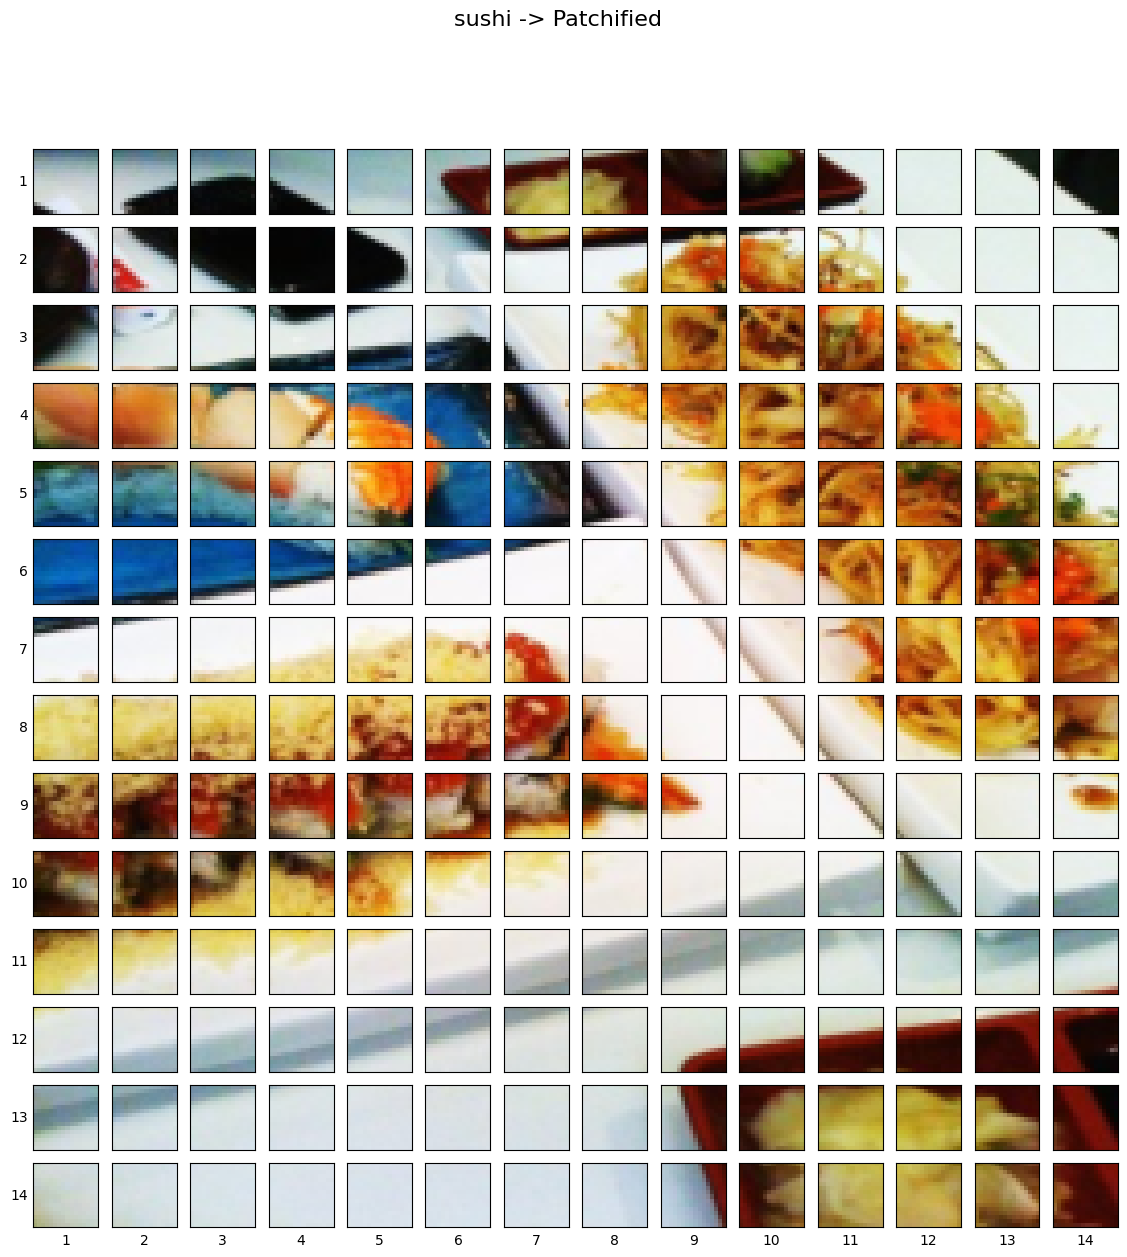

In [65]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Turning Images into Patches using PyTorch (CNNs)

In [66]:
from torch import nn

# Set the patch size
patch_size = 16

# Create the conv2d layer with Hyperparameters settings from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                    out_channels=768,  # from Table 1: Hidden size D, this is the embedding size
                    kernel_size=patch_size, # We can also write (patch_size, patch_size)
                    stride=patch_size,
                    padding=0)

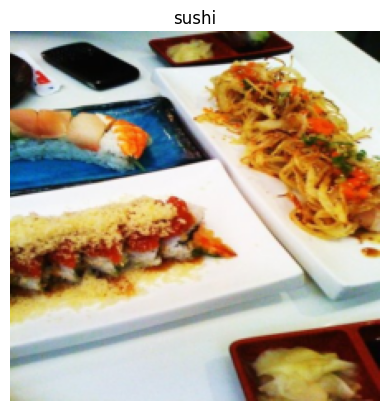

In [67]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [68]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [127, 683, 326, 618, 498]


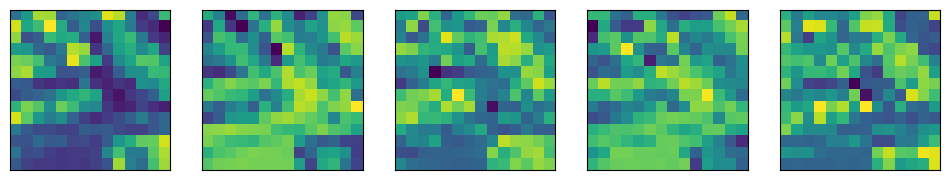

In [69]:
# Import random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 767), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[ : , idx, : , : ] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [70]:
# Getting a single feature map out in a tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517,
           -0.1883, -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001],
          [ 0.1144, -1.0577, -0.0710,  0.0083,  0.0727, -0.9256, -0.6416,
           -0.8521, -0.8934, -0.7018, -0.9052, -0.9847, -0.9749, -1.0478],
          [-0.1704, -0.8053, -0.8679, -0.8285, -0.9246, -0.6688, -0.9587,
           -1.0630, -0.5454, -0.4330, -0.4856, -0.5460, -0.9633, -0.9834],
          [-0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,  0.0774,
           -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423],
          [-0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635,
           -0.5493, -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628],
          [-0.1667, -0.2729, -0.4155, -0.3927, -0.3325, -0.8999, -1.0067,
           -1.0335, -0.9814, -0.9558, -0.5720, -0.5380, -0.5040, -0.5470],
          [-1.0526, -1.0946, -1.0253, -1.0834, -0.9792, -0.9339, -0.6786,
           -1.0560, -1.0755, -0.

In [71]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


#### Creating a flatten layer to flatten the height and width dimensions of the feature map.

In [72]:
flatten = nn.Flatten(start_dim=2, # flatten feature map height (dimension 2)
                    end_dim=3) # flatten feature map width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature mape shape: torch.Size([1, 768, 196])


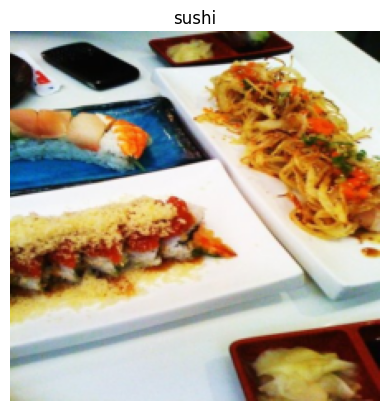

In [73]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # unsqueeze to add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten out the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature mape shape: {image_out_of_conv_flattened.shape}")



In [74]:
# Getting flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


#### Visualiziing one Image Patch Embedding

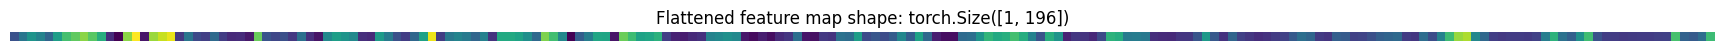

In [75]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [76]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.8176, -0.6418, -0.4872, -0.5758, -0.7243, -0.4365, -0.2517, -0.1883,
          -0.1010, -0.2052, -0.3501, -0.9703, -1.1312, -0.1001,  0.1144, -1.0577,
          -0.0710,  0.0083,  0.0727, -0.9256, -0.6416, -0.8521, -0.8934, -0.7018,
          -0.9052, -0.9847, -0.9749, -1.0478, -0.1704, -0.8053, -0.8679, -0.8285,
          -0.9246, -0.6688, -0.9587, -1.0630, -0.5454, -0.4330, -0.4856, -0.5460,
          -0.9633, -0.9834, -0.4468, -0.6124, -0.8217, -0.9025, -0.7151, -0.4206,
           0.0774, -0.9059, -0.6263, -0.5677, -0.6230, -0.7193, -0.5842, -0.9423,
          -0.3769, -0.3758, -0.4067, -0.5090, -0.7041, -0.1277, -0.2635, -0.5493,
          -1.1305, -0.7572, -0.6042, -0.3964, -0.3973, -1.0628, -0.1667, -0.2729,
          -0.4155, -0.3927, -0.3325, -0.8999, -1.0067, -1.0335, -0.9814, -0.9558,
          -0.5720, -0.5380, -0.5040, -0.5470, -1.0526, -1.0946, -1.0253, -1.0834,
          -0.9792, -0.9339, -0.6786, -1.0560, -1.0755, -0.9244, -0.9415, -0.6630,
          -0.687

### Creating a PatchEmbedding Class in PyTorch

In [83]:
# Creating a class which subclasses the nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # Initializing the class with appropriate variables
    def __init__(self,
                in_channels:int=3, # Input color channels
                patch_size:int=16, # Patch size: 16 for the ViT Base Model
                embedding_dim:int=768): # Embedding Dimensions are 768 for the ViT Base Model as stated in the ViT paper
        super().__init__()

        # Creating a layer to turn the image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

        # Creating a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                end_dim=3) # only flatten the feature map dimensions into a single vector

    # Define the forward method
    def forward(self, x):
        # Create assertion to check the inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # Make sure the output image shape has the right order
        return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [84]:
# Trying out the PatchEmbedding layer
set_seeds()

# Creating a instance of the PatchEmbedding layer
patchify =  PatchEmbedding(in_channels=3,
                            patch_size=16,
                            embedding_dim=768)

# Passing a single image through the patchify layer
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [85]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

### Creating the class token embedding